
# Fused Softmax

In this tutorial, you will write a fused softmax operation that is significantly faster
than PyTorch's native op for a particular class of matrices: those whose rows can fit in
the GPU's SRAM.

In doing so, you will learn about:

* The benefits of kernel fusion for bandwidth-bound operations.

* Reduction operators in Triton.


## Motivations

Custom GPU kernels for elementwise additions are educationally valuable but won't get you very far in practice.
Let us consider instead the case of a simple (numerically stabilized) softmax operation:



In [1]:
import torch

import triton
import triton.language as tl


@torch.jit.script
def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

In [2]:
import torch
x = torch.Tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

x_max = x.max(dim=1)[0]
z = x - x_max[:, None]
print(z)

tensor([[-2., -1.,  0.],
        [-2., -1.,  0.]])


When implemented naively in PyTorch, computing :code:`y = naive_softmax(x)` for $x \in R^{M \times N}$
requires reading $5MN + 2M$ elements from DRAM and writing back $3MN + 2M$ elements.
This is obviously wasteful; we'd prefer to have a custom "fused" kernel that only reads
X once and does all the necessary computations on-chip.
Doing so would require reading and writing back only $MN$ bytes, so we could
expect a theoretical speed-up of ~4x (i.e., $(8MN + 4M) / 2MN$).
The `torch.jit.script` flags aims to perform this kind of "kernel fusion" automatically
but, as we will see later, it is still far from ideal.



In [9]:
m = torch.nn.Softmax(dim=0)
input = torch.ones(2, 3)
output = m(input)
print(output)

tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]])


## Compute Kernel

Our softmax kernel works as follows: each program loads a row of the input matrix X,
normalizes it and writes back the result to the output Y.

Note that one important limitation of Triton is that each block must have a
power-of-two number of elements, so we need to internally "pad" each row and guard the
memory operations properly if we want to handle any possible input shapes:



In [2]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_cols, BLOCK_SIZE: tl.constexpr):
    # The rows of the softmax are independent, so we parallelize across those
    row_idx = tl.program_id(0)
    # The stride represents how much we need to increase the pointer to advance 1 row
    row_start_ptr = input_ptr + row_idx * input_row_stride
    # The block size is the next power of two greater than n_cols, so we can fit each
    # row in a single block
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets
    # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
    row = tl.load(input_ptrs, mask=col_offsets < n_cols, other=-float('inf'))
    # Subtract maximum for numerical stability
    row_minus_max = row - tl.max(row, axis=0)
    # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator, axis=0)
    softmax_output = numerator / denominator
    # Write back output to DRAM
    output_row_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=col_offsets < n_cols)

We can create a helper function that enqueues the kernel and its (meta-)arguments for any given input tensor.



In [3]:
def softmax(x):
    n_rows, n_cols = x.shape
    # The block size is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16
    # Allocate output
    y = torch.empty_like(x)
    # Enqueue kernel. The 1D launch grid is simple: we have one kernel instance per row o
    # f the input matrix
    softmax_kernel[(n_rows, )](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_cols,
        num_warps=num_warps,
        BLOCK_SIZE=BLOCK_SIZE,
    )
    return y

## Unit Test



We make sure that we test our kernel on a matrix with an irregular number of rows and columns.
This will allow us to verify that our padding mechanism works.



In [4]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device='cuda')
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

As expected, the results are identical.



## Benchmark

Here we will benchmark our operation as a function of the number of columns in the input matrix -- assuming 4096 rows.
We will then compare its performance against (1) :code:`torch.softmax` and (2) the :code:`naive_softmax` defined above.



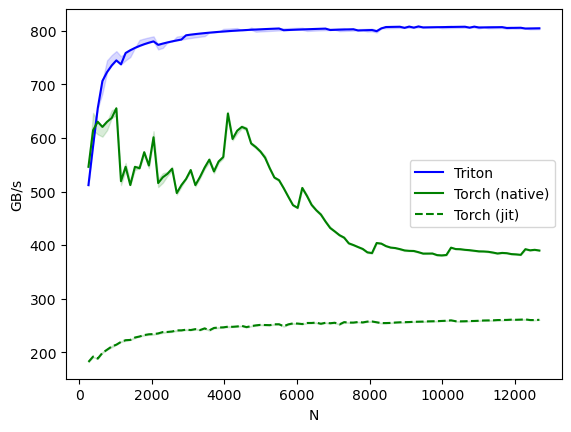

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  512.000001      546.133347   182.044442
1     384.0  585.142862      614.400016   192.000000
2     512.0  655.360017      630.153853   188.321838
3     640.0  706.206879      620.606056   198.834954
4     768.0  722.823517      630.153868   204.800005
..      ...         ...             ...          ...
93  12160.0  805.631452      381.864588   260.979218
94  12288.0  804.122702      392.431159   261.441378
95  12416.0  804.275339      390.286855   260.191227
96  12544.0  804.424824      391.235863   260.147766
97  12672.0  804.571435      389.913540   260.606688

[98 rows x 4 columns]


In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True)

In the above plot, we can see that:
 - Triton is 4x faster than the Torch JIT. This confirms our suspicions that the Torch JIT does not do any fusion here.
 - Triton is noticeably faster than :code:`torch.softmax` -- in addition to being **easier to read, understand and maintain**.
   Note however that the PyTorch `softmax` operation is more general and will work on tensors of any shape.

